# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [4]:
DATA_FOLDER = '../../ADA2017-Tutorials/02 - Intro to Pandas/Data/' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

We start by having a look at the files: 

In [9]:
!cat '../../ADA2017-Tutorials/02 - Intro to Pandas/Data/ebola/guinea_data/2014-09-11.csv' | head -n 2 
! echo "\n"
!cat '../../ADA2017-Tutorials/02 - Intro to Pandas/Data/ebola/liberia_data/2014-09-17-v125.csv' | head -n 2
! echo "\n"
!cat '../../ADA2017-Tutorials/02 - Intro to Pandas/Data/ebola/sl_data/2014-08-18-v83.csv' | head -n 2
! echo "\n"

Date,Description,Totals,Conakry,Gueckedou,Macenta,Dabola,Kissidougou,Dinguiraye,Telimele,Boffa,Kouroussa,Siguiri,Pita,Mzerekore,Yomou,Dubreka,Forecariah,Kerouane,Coyah,Dalaba,Beyla,Kindia,Lola
2014-09-11,New cases of suspects,9,,4,1,,,,,,,,,,,,1,3,,,,,


Date,Variable,National,Bomi County,Bong County,Gbarpolu County,Grand Bassa,Grand Cape Mount,Grand Gedeh,Grand Kru,Lofa County,Margibi County,Maryland County,Montserrado County,Nimba County,River Gee County,RiverCess County,Sinoe County
9/17/2014,Specimens collected,,,,,,,,,,,,,,,,


date,variable,Kailahun,Kenema,Kono,Kambia,Koinadugu,Bombali,Tonkolili,Port Loko,Pujehun,Bo,Moyamba,Bonthe,Western area urban,Western area rural,National
2014-08-18,population,"465,048","653,013","325,003","341,690","335,471","494,139","434,937","557,978","335,574","654,142","278,119","168,729","1,040,888","263,619","6,348,350"




We can see that each country has is own schema, however the schemas look the same in the form : <br/>
* Date
* Description/Variable
* Total/National
* Countys

Let's have a look at the possible values of the second field :

`cat ../../ADA2017-Tutorials/02-\ Intro\ to\ Pandas/Data/ebola/*/* |  cut -d, -f2  | sort | uniq`

We have indication about the number of death and new case (and others).

Several fields have quiet the same meaning ; for instance : new deaths registered and new deaths registered today.

We need to compute the total number of new cases and deaths by day, so we need do sum this field to have a total.

So we will build a table like this  with new case and death in columns:
Date, Country, County, NCountyew case, death ...

This table wille be much easier to compute for statistical.

However the data are in "tranpose" format, so we will tranpose it to have it in good shape for statistical analysis.


In [142]:
data = pd.DataFrame() # empty table

# Limit the number of file to load : for debug purpose
max_file = 10000
max_file_i = 0

# Browse all csv file
for csv in glob.glob(DATA_FOLDER + "ebola/*/*.csv"): 
    
    # Read the csv and replace '-' by nan, because "-" apers sometime
    subframe =  pd.read_csv(csv, na_values="-")
    
    # Rewrite columns indexes by lowercases
    subframe.columns = [x.lower() for x in subframe.columns]
    
    # Rename 'description' to 'variable' (those columns are equivalent)
    if(subframe.columns[1]=="description") : 
        subframe.rename(columns={'description': 'variable'}, inplace=True)

    # Verify that the date is unique by files
    assert len(subframe['date'].drop_duplicates()) == 1
    uniquedate = pd.to_datetime(subframe['date'][0])
    
    # Remove the date column
    subframe.drop('date', axis=1, inplace=True)
    
    # Place 'variable' in indexes. Hence, after the transposition, variable will become columns
    subframe = subframe.set_index("variable")
    
    # Transpose the Dataframe : 'variable' becomes column names and regions name are indexes. 
    subframe = subframe.transpose()
    
    # Again, put all indexs in lowercases
    subframe.columns = [x.lower() for x in subframe.columns]
    
    # Convert if possible data to number
    subframe = subframe.apply(pd.to_numeric,errors='ignore')
    
    # Put back the date
    subframe['date'] = uniquedate

    # Add a column for the country, depending on the file
    if "guinea" in csv :
        subframe['country'] = "Guinea"
    if "liberia" in csv :
        subframe['country'] = "Liberia"
    if "sl" in csv :
        subframe['country'] = "Sierra Leone"
        

    # Reset index to have no county in index
    subframe.reset_index(level=0, inplace=True)  
    
    # Rename index to regions
    subframe.rename(columns={'index': 'regions'}, inplace=True)

    # Remove duplicated columns
    subframe = subframe.loc[:,~subframe.columns.duplicated()]

    # Reorder column names : first date, country, regions
    #cols = ['date','country','regions'] + [col for col in subframe if (col != 'date' and col != 'country' and col != 'regions') ]
    #subframe = subframe[cols]
    
    # Concatenate the file with the global dataframe
    data = pd.concat([data,subframe], axis=0, ignore_index=True)
    # Reorder columns
    cols = ['date','country','regions']  + [col for col in data if (col != 'date' and col != 'country' and col != 'regions') ]
    data = data[cols]
       
    # Break the loop if too much files
    if(max_file_i>max_file):
           break
    max_file_i +=1

data.shape

(3588, 144)

We add the 2 columns for new cases and deaths by day. <br>
We arbitrary chose to count each of <b>probable, suspect, and confirmed</b> cases.

In [143]:
data['total_new_death'] = data['new deaths registered'].fillna(0) + \
                        data['new deaths registered today'].fillna(0) + \
                        data['newly reported deaths'].fillna(0) + \
                        data['etc_new_deaths'].fillna(0)

data['total_newcase'] = data["total new cases registered so far"].fillna(0) + \
                        data['new case/s (confirmed)'].fillna(0) + \
                        data['new case/s (probable)'].fillna(0) + \
                        data['new case/s (suspected)'].fillna(0) + \
                        data['new_confirmed'].fillna(0) + \
                        data['new_probable'].fillna(0) + \
                        data['new_suspected'].fillna(0); 

And finaly compute the daily mean by country, and by month 

In [243]:
gb_data = data[data['regions'].isin(["national" ,"totals"])].set_index("date").groupby(['country',pd.TimeGrouper(freq='M')])

n_c_mean = gb_data['total_newcase'].mean()
n_c_mean

country       date      
Guinea        2014-08-31      25.800000
              2014-09-30      19.625000
              2014-10-31      34.000000
Liberia       2014-06-30       5.714286
              2014-07-31       8.545455
              2014-08-31      37.222222
              2014-09-30      63.833333
              2014-10-31      45.560000
              2014-11-30      26.466667
              2014-12-31    5178.555556
Sierra Leone  2014-08-31      25.150000
              2014-09-30      40.689655
              2014-10-31      70.928571
              2014-11-30      75.238095
              2014-12-31      41.000000
Name: total_newcase, dtype: float64

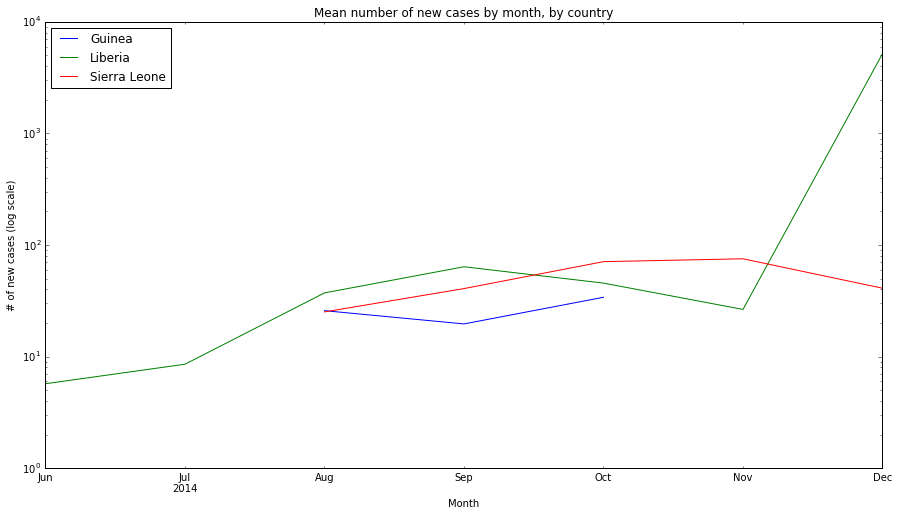

In [247]:
plt.figure(figsize=(15, 8))
#n_c_mean.drop([('Liberia', pd.to_datetime('2014-12-31'))]).plot()
n_c_mean.loc['Guinea'].plot(logy = True)
n_c_mean.loc['Liberia'].plot(logy = True)
n_c_mean.loc['Sierra Leone'].plot(logy = True)
plt.legend(['Guinea', 'Liberia', 'Sierra Leone'], loc='upper left')
plt.ylabel("# of new cases (log scale)")
plt.xlabel("Month")
plt.title('Mean number of new cases by month, by country')
#plt.xlim((pd.to_datetime('2014-06-30'),pd.to_datetime('2015-01-31')))

In [246]:
deaths_mean = gb_data['total_new_death'].mean()
deaths_mean

country       date      
Guinea        2014-08-31     3.400000
              2014-09-30     3.562500
              2014-10-31    15.000000
Liberia       2014-06-30     2.000000
              2014-07-31     4.272727
              2014-08-31    23.222222
              2014-09-30    36.041667
              2014-10-31    28.040000
              2014-11-30    13.466667
              2014-12-31     0.000000
Sierra Leone  2014-08-31     0.000000
              2014-09-30     0.275862
              2014-10-31     3.535714
              2014-11-30     0.571429
              2014-12-31     2.200000
Name: total_new_death, dtype: float64

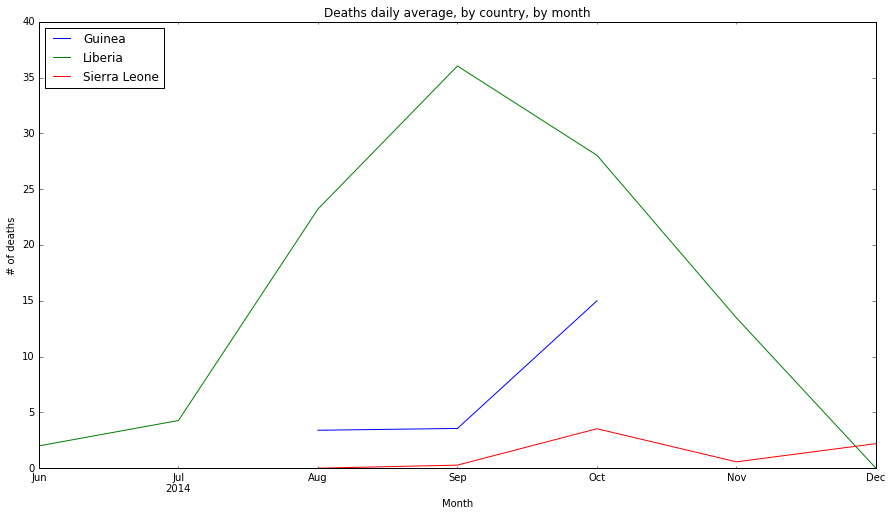

In [211]:
plt.figure(figsize=(15, 8))
#n_c_mean.drop([('Liberia', pd.to_datetime('2014-12-31'))]).plot()
deaths_mean.loc['Guinea'].plot()
deaths_mean.loc['Liberia'].plot()
deaths_mean.loc['Sierra Leone'].plot()
plt.legend(['Guinea', 'Liberia', 'Sierra Leone'], loc='upper left')
plt.ylabel("# of deaths")
plt.xlabel("Month")
plt.title('Deaths daily average, by country, by month')
#plt.xlim((pd.to_datetime('2014-06-30'),pd.to_datetime('2015-01-31')))

By seeing the drop of deaths in decembre for Liberia, we can imagine that there is an error in the exploding number of new cases for the same country

In [288]:
lib_expect = n_c_mean.iloc[8:10,].copy()
lib_expect[1] = 5
lib_expect

country  date      
Liberia  2014-11-30    26.466667
         2014-12-31     5.000000
Name: total_newcase, dtype: float64

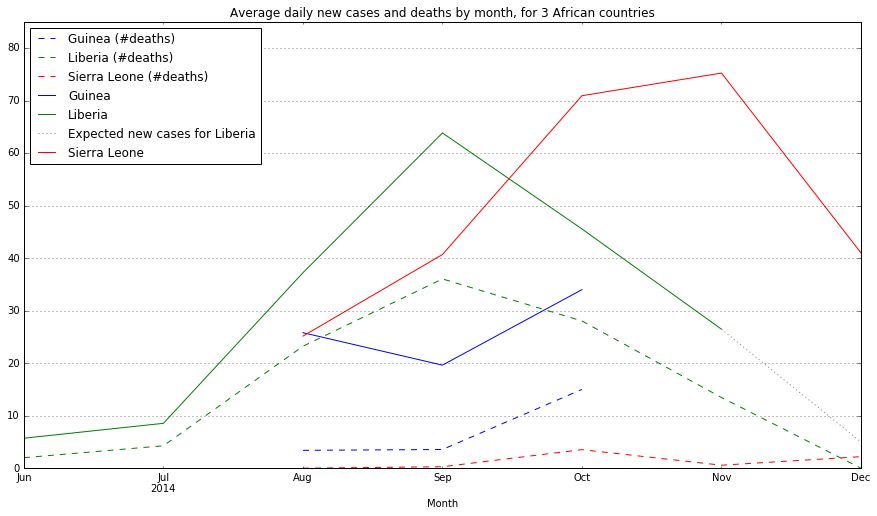

In [297]:
plt.figure(figsize=(15, 8))
deaths_mean.loc['Guinea'].plot(color='blue', style='--')
deaths_mean.loc['Liberia'].plot(color='green', style='--')
deaths_mean.loc['Sierra Leone'].plot(color='red', style='--')
n_c_mean.loc['Guinea'].plot(color='blue', style='-')
n_c_mean.loc['Liberia'].drop(pd.to_datetime('2014-12-31')).plot(color='green')
#n_c_mean.loc['Liberia'].iloc[-2:,].plot(color='black', style=':')
lib_expect['Liberia'].plot(color='grey', style = ':')
n_c_mean.loc['Sierra Leone'].plot(color='red')


plt.legend(['Guinea (#deaths)', 'Liberia (#deaths)', 'Sierra Leone (#deaths)', \
            'Guinea', 'Liberia', 'Expected new cases for Liberia', 'Sierra Leone'], loc='upper left')
plt.xlabel("Month")
plt.ylim(0,85)
plt.title("Average daily new cases and deaths by month, for 3 African countries")
plt.grid(True)

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

Here, each xml file have a bacterie name and a value.The name of file is he same as the name in the metadata.xml 

To begin , we merge xml file with bacterie name for key, after we rename collumn with name in metadata. 

In [3]:
files_name = os.listdir(DATA_FOLDER + 'microbiome/')

In [4]:
rna_data = pd.DataFrame()

for e,f in enumerate(list(filter(lambda n: 'MID' in n, files_name))) :
    tmp = pd.read_excel(DATA_FOLDER + 'microbiome/' + f, 'Sheet 1', index_col=0, header=None)
    #tmp.columns = ['MID'+ str(e+1)]  
    rna_data = pd.concat([rna_data, tmp], axis=1)

rna_data.fillna("unknown", inplace = True)
rna_data.index.name = 'Taxonomy'  

Let's have a look at what we find in the metadata :

In [5]:
meta = pd.read_excel(DATA_FOLDER+"microbiome/metadata.xls")
meta.fillna("unknown", inplace = True)
meta

,BARCODE,GROUP,SAMPLE
0,MID1,EXTRACTION CONTROL,unknown
1,MID2,NEC 1,tissue
2,MID3,Control 1,tissue
3,MID4,NEC 2,tissue
4,MID5,Control 2,tissue
5,MID6,NEC 1,stool
6,MID7,Control 1,stool
7,MID8,NEC 2,stool
8,MID9,Control 2,stool


We will add the values of metadata as columns in the data, and columns of metadata as column names : <br>


Metadata's values $\rightarrow$ Data's columns <br>
Metadata's columns $\rightarrow$ Data's columns name

In [6]:
rna_data.columns = meta.transpose().values.tolist()[::-1]
rna_data.columns.names = meta.transpose().index.values.tolist()[::-1]
rna_data.head()

SAMPLE                                                        unknown  \
GROUP                                              EXTRACTION CONTROL   
BARCODE                                                          MID1   
Taxonomy                                                                
Archaea "Crenarchaeota" Thermoprotei Acidilobal...            unknown   
Archaea "Crenarchaeota" Thermoprotei Acidilobal...            unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...                  7   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...            unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...            unknown   

SAMPLE                                               tissue            \
GROUP                                                 NEC 1 Control 1   
BARCODE                                                MID2      MID3   
Taxonomy                                                                
Archaea "Crenarchaeota" Thermoprotei Acidilobal...        2         1   
Archaea "Crenarchaeota" Thermoprotei Acidilobal...       14        15   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...       23        14   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown   unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...        1         4   

SAMPLE                                                                 \
GROUP                                                 NEC 2 Control 2   
BARCODE                                                MID4      MID5   
Taxonomy                                                                
Archaea "Crenarchaeota" Thermoprotei Acidilobal...  unknown         5   
Archaea "Crenarchaeota" Thermoprotei Acidilobal...  unknown        26   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...        2        28   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown         1   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown         5   

SAMPLE                                                stool            \
GROUP                                                 NEC 1 Control 1   
BARCODE                                                MID6      MID7   
Taxonomy                                                                
Archaea "Crenarchaeota" Thermoprotei Acidilobal...  unknown   unknown   
Archaea "Crenarchaeota" Thermoprotei Acidilobal...  unknown         1   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...        7         8   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown   unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...        1         2   

SAMPLE                                                                 
GROUP                                                 NEC 2 Control 2  
BARCODE                                                MID8      MID9  
Taxonomy                                                               
Archaea "Crenarchaeota" Thermoprotei Acidilobal...  unknown   unknown  
Archaea "Crenarchaeota" Thermoprotei Acidilobal...  unknown         1  
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown        16  
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown   unknown  
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown         2

Let's finally check that the indexes are unique :

In [7]:
rna_data.index.is_unique

True

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [11]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

### <font face="verdana" color="blue">1. Type and value range of attributes</font>


| Attribut       |   pclass |  suvived  |  name  |  sex        |  age     |  sibsp  |  parck  |  ticket     |  fare      |  cabin  |  embarked  |  boat    |  body   |  home.dest |
| -------------- | -------- | --------- | ------ | ----------- | -------- | ------- | ------- | ----------- | ---------- | ------- | ---------- | -------- | ------- | ---------- |
| **type**           | integer  | Boolean   | string | Bolean      | interger | integer | integer | String      | float      | String  | Char       | Sttring  | integer | String     |
| **Value range**    | 1/2/3    | 1/2       | text   | male/female | 0 to 100 | 0-3     | 0-4     | PC + number | 0 to 100.0 | text    | S-C-Q      | D ou 1-9 | >0      | city name  |
| **Categorisation** | Yes      | Yes       | No    | Yes         | No       | No      | No      | No          | No         | No     | Yes        | No       | No      | No         |

In [13]:
# load data with categorization

data  = pd.read_excel(DATA_FOLDER+"titanic.xls", \
                      type={'pclass':'category','survived':'category','sex':'category','embarked':'category'})

###  <font face="verdana" color="blue">2. Histograms for several attributes </font>
<p align="right"><font color="#0094ff"> **Attributes :** Travel class, Embarkation port, Sex and Age </font></p>


For each case we use the groupby function, and then take the size of categories :

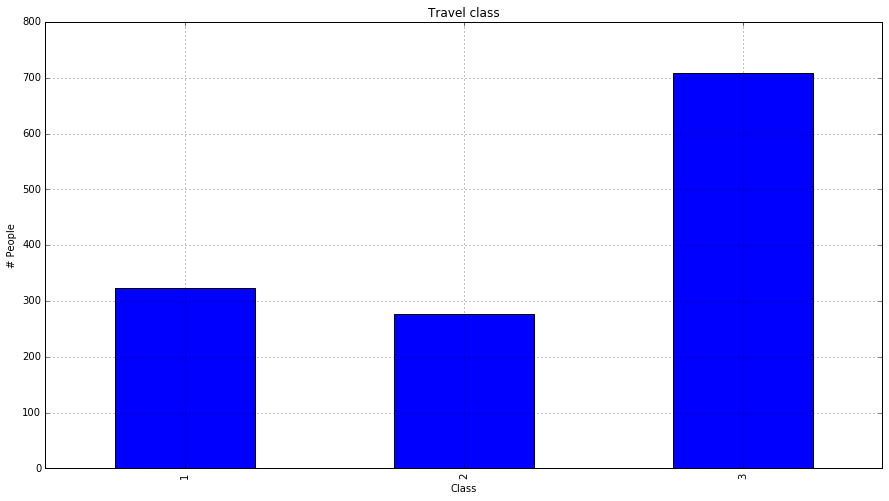

In [59]:
plt.figure(figsize=(15, 8))
data.groupby('pclass').size().plot(kind='bar')
plt.title('Travel class')
plt.grid()
plt.xlabel('Class')
plt.ylabel('# People')

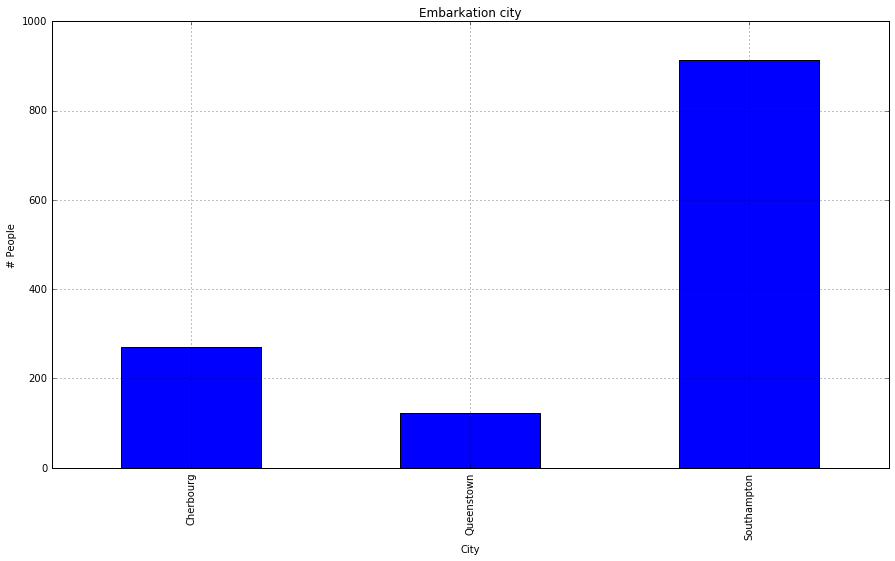

In [60]:
plt.figure(figsize=(15, 8))
tmp = data.groupby('embarked').size()
tmp.index = ['Cherbourg', 'Queenstown', 'Southampton']
tmp.plot(kind='bar')
plt.title('Embarkation city')
plt.grid()
plt.xlabel('City')
plt.ylabel('# People')

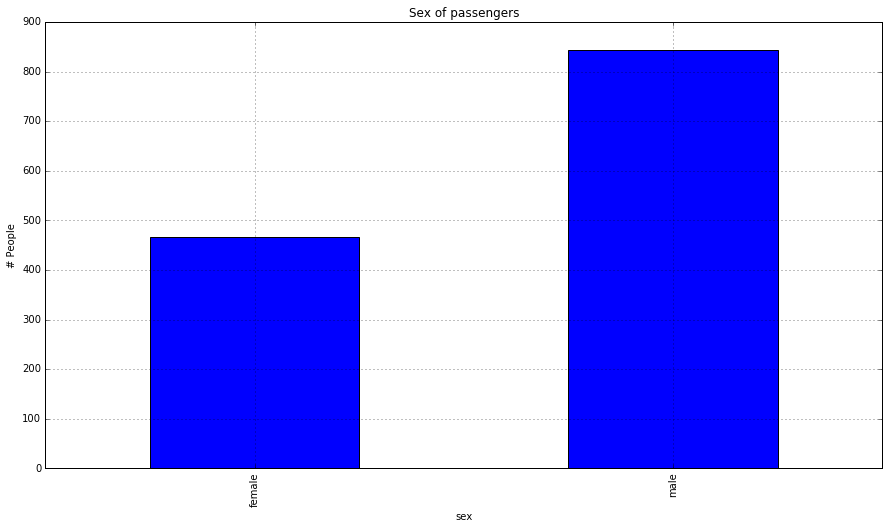

In [61]:
plt.figure(figsize=(15, 8))
data.groupby('sex').size().plot(kind='bar')
plt.title('Sex of passengers')
plt.ylabel('# People')
plt.grid(True)

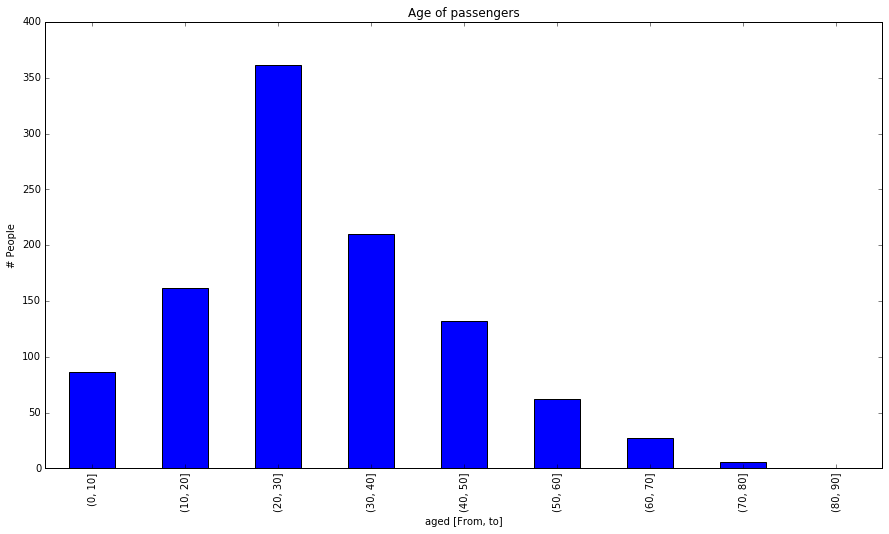

In [77]:
plt.figure(figsize=(15, 8))
pd.cut(data['age'], bins = 10 * np.arange(0,10)).value_counts(sort=False).plot(kind='bar')
plt.title('Age of passengers')
plt.xlabel('aged [From, to]')
plt.ylabel('# People')

Here we separated the ages in decades intervals, with the 
<div class="alert alert-block alert-info"> pandas.cut()</div>function

###  <font face="verdana" color="blue">3. Passengers by cabin floor in a pie chart</font>

C    31.864407
B    22.033898
D    15.593220
E    13.898305
A     7.457627
F     7.118644
G     1.694915
T     0.338983
Name: cabin, dtype: float64


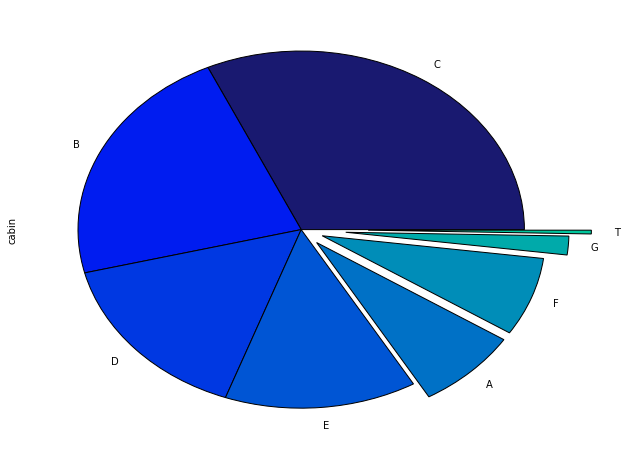

In [97]:
cabine = data['cabin']
# We remove pasenger without cabine and get first letter(levvel) 
cabinefloor = cabine[cabine.notnull()].str[0]
# We calculate the proportion with value_count/sum
proportion = cabinefloor.value_counts()/(cabinefloor.value_counts().sum())
print(proportion*100)
plt.figure(figsize=(10,8))
colors = ['#191970','#001CF0','#0038E2','#0055D4','#0071C6','#008DB8','#00AAAA','#00C69C','#00E28E','#00FF80']
expl = (0, 0, 0, 0, 0.1,0.1, 0.2, 0.3)
proportion.plot.pie(colors = colors, explode = expl)

###  <font face="verdana" color="blue">4. Surviving passengers by class, in a pie chart</font>
Group by to get passengers by pclass, then compute the survival proportion.

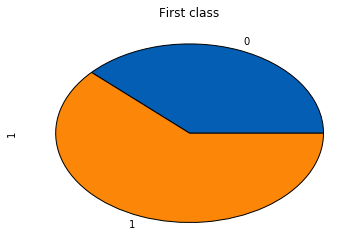

In [120]:
groupsuvived = data.groupby("pclass").apply( lambda x : x['survived'].value_counts(sort=False)/(x['survived'].value_counts().sum())  ) 
groupsuvived = groupsuvived.transpose()
#for i in range(1,4):
    #print(groupsuvived[i])
colors = ['#045FB4', '#FC8607']
groupsuvived[1].plot.pie(colors = colors, title='First class')

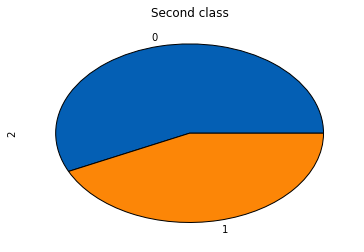

In [121]:
groupsuvived[2].plot.pie(colors = colors, title='Second class')

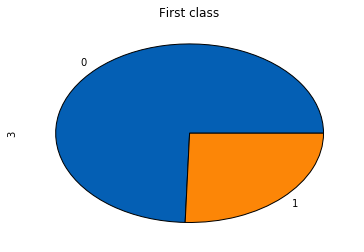

In [124]:
groupsuvived[3].plot.pie(colors=colors, title='First class')

5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

###  <font face="verdana" color="blue">5. Surviving proportion by class & sex </font>


We do the same as before but group by pclass **and** sex.

In [17]:
gbsexclass = data.groupby(["pclass","sex"])
gbsexclass = gbsexclass.apply( lambda x : x['survived'].value_counts(sort=False)/(x['survived'].value_counts().sum())  )
gbsexclass = gbsexclass.transpose()
gbsexclass = gbsexclass.drop(0)
gbsexclass

pclass           1                   2                   3         
sex         female      male    female      male    female     male
survived                                                           
1         0.965278  0.340782  0.886792  0.146199  0.490741  0.15213

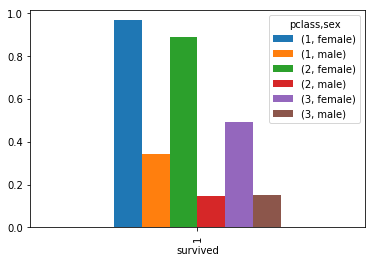

In [18]:
gbsexclass.plot(kind="bar")

###  <font face="verdana" color="blue">6. Survival proportions.... </font>

Idem, but we use decade interval

In [19]:
datawithcat =  data
datawithcat['age_cat'] =  pd.cut(data['age'],2)
datawithcat = data.groupby(["pclass","sex","age_cat"]).apply( lambda x : x['survived'].value_counts(sort=False)/(x['survived'].value_counts().sum())  )
datawithcat

survived                               0         1
pclass sex    age_cat                             
1      female (0.0869, 40.083]  0.036145  0.963855
              (40.083, 80.0]    0.040000  0.960000
       male   (0.0869, 40.083]  0.555556  0.444444
              (40.083, 80.0]    0.734177  0.265823
2      female (0.0869, 40.083]  0.091954  0.908046
              (40.083, 80.0]    0.187500  0.812500
       male   (0.0869, 40.083]  0.830645  0.169355
              (40.083, 80.0]    0.941176  0.058824
3      female (0.0869, 40.083]  0.514286  0.485714
              (40.083, 80.0]    0.666667  0.333333
       male   (0.0869, 40.083]  0.817891  0.182109
              (40.083, 80.0]    0.944444  0.055556

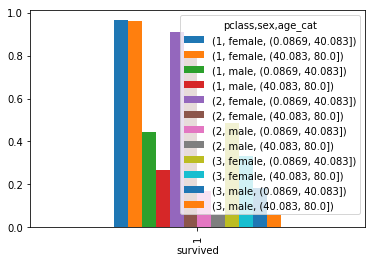

In [26]:
datawithcat.transpose().drop(0).plot(kind='bar')